In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import re
from datetime import datetime

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

plt.rcParams.update({'font.size': 10})

In [2]:
def parse_timestamp(fname):
    m = re.search(r'T(\d{8})_(\d{6})M', fname.name)
    if m:
        return datetime.strptime(m.group(1) + m.group(2), '%Y%m%d%H%M%S')
    return None

def extract_features(img):
    """Extract features optimized for MAGIC telescope mirror images."""
    features = {}
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # ── Mask out central camera housing ──
    mask = np.ones((h, w), dtype=np.uint8) * 255
    cam_y, cam_x = int(h * 0.38), int(w * 0.52)
    cv2.circle(mask, (cam_x, cam_y), int(min(h,w)*0.12), 0, -1)
    valid = gray[mask > 0]

    # ── A) GLOBAL BRIGHTNESS ──
    features['mean_brightness'] = np.mean(valid)
    features['std_brightness'] = np.std(valid)
    features['p10_brightness'] = np.percentile(valid, 10)
    features['p90_brightness'] = np.percentile(valid, 90)
    features['dynamic_range'] = features['p90_brightness'] - features['p10_brightness']

    # ── B) LENS FLARE / DIRECT SUN DETECTION ──
    # Key insight: lens flare creates high-saturation, high-value pixels
    # that are warm-colored (yellow/orange), unlike regular mirror reflections

    # Warm bright pixels (sun/flare signature)
    hue = hsv[:,:,0].astype(float)
    sat = hsv[:,:,1].astype(float)
    val = hsv[:,:,2].astype(float)

    # Lens flare is typically warm (H < 30 or H > 160 in OpenCV) AND bright AND saturated
    warm_bright = ((hue < 25) | (hue > 160)) & (val > 180) & (sat > 60) & (mask > 0)
    features['warm_bright_fraction'] = np.sum(warm_bright) / np.sum(mask > 0)

    # General bright + saturated (any color)
    bright_saturated = (val > 200) & (sat > 80) & (mask > 0)
    features['bright_saturated_frac'] = np.sum(bright_saturated) / np.sum(mask > 0)

    # ── C) SPATIAL ASYMMETRY ──
    # Strong indicator of directional sunlight
    left_mean = np.mean(gray[:, :w//3])
    right_mean = np.mean(gray[:, 2*w//3:])
    top_mean = np.mean(gray[:h//3, :])
    bottom_mean = np.mean(gray[2*h//3:, :])

    features['LR_asymmetry'] = left_mean - right_mean  # signed! positive = brighter left
    features['LR_asymmetry_abs'] = abs(features['LR_asymmetry'])
    features['TB_asymmetry'] = top_mean - bottom_mean
    features['TB_asymmetry_abs'] = abs(features['TB_asymmetry'])

    # ── D) SKY REGION ANALYSIS ──
    # The sky is visible in the top corners and edges
    sky_top = gray[:h//6, :]
    features['sky_brightness'] = np.mean(sky_top)
    features['sky_blue_ratio'] = np.mean(img[:h//6, :, 0]) / (np.mean(img[:h//6, :, 2]) + 1)

    # ── E) COLOR STATISTICS ──
    features['mean_saturation'] = np.mean(sat[mask > 0])
    features['mean_hue'] = np.mean(hue[mask > 0])
    features['BR_ratio'] = (np.mean(img[:,:,0].astype(float)) + 1) / (np.mean(img[:,:,2].astype(float)) + 1)

    # Lab color: a* channel (green-red axis) - warm sunlight shifts this
    features['mean_a_channel'] = np.mean(lab[:,:,1].astype(float))
    features['mean_b_channel'] = np.mean(lab[:,:,2].astype(float))  # blue-yellow axis

    # ── F) TEXTURE / EDGE METRICS ──
    # Lens flare reduces local contrast in affected areas
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features['sharpness'] = np.std(laplacian)

    # ── G) HISTOGRAM FEATURES ──
    hist = cv2.calcHist([gray], [0], mask, [256], [0, 256]).flatten()
    hist_norm = hist / (hist.sum() + 1e-6)
    features['entropy'] = -np.sum(hist_norm[hist_norm > 0] * np.log2(hist_norm[hist_norm > 0]))

    # Fraction of very dark pixels (shadow indicator)
    features['dark_fraction'] = np.sum(valid < 40) / len(valid)
    # Fraction of very bright pixels
    features['bright_fraction'] = np.sum(valid > 220) / len(valid)

    return features

In [ ]:
img_dir = Path("/media/pgliwny/ADATA HD3303/Computer_Vision_system/data/MAGIC/IRCam/IRCamera/2025/12/16/")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))

In [7]:
img_dir = Path("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/12/17")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))

In [26]:
images, timestamps, labels, fnames = [], [], [], []

for f in files[::5]:
    images.append(cv2.imread(str(f)))
    ts = parse_timestamp(f)
    labels.append(ts.strftime("%d/%m\n%H:%M"))
    fnames.append(f.name)

i

In [27]:
all_features = []
features_names = None

for img in images:
    feats = extract_features(img)
    all_features.append(feats)
    if features_names is None:
        features_names = list(feats.keys())

In [19]:
len(images)

18

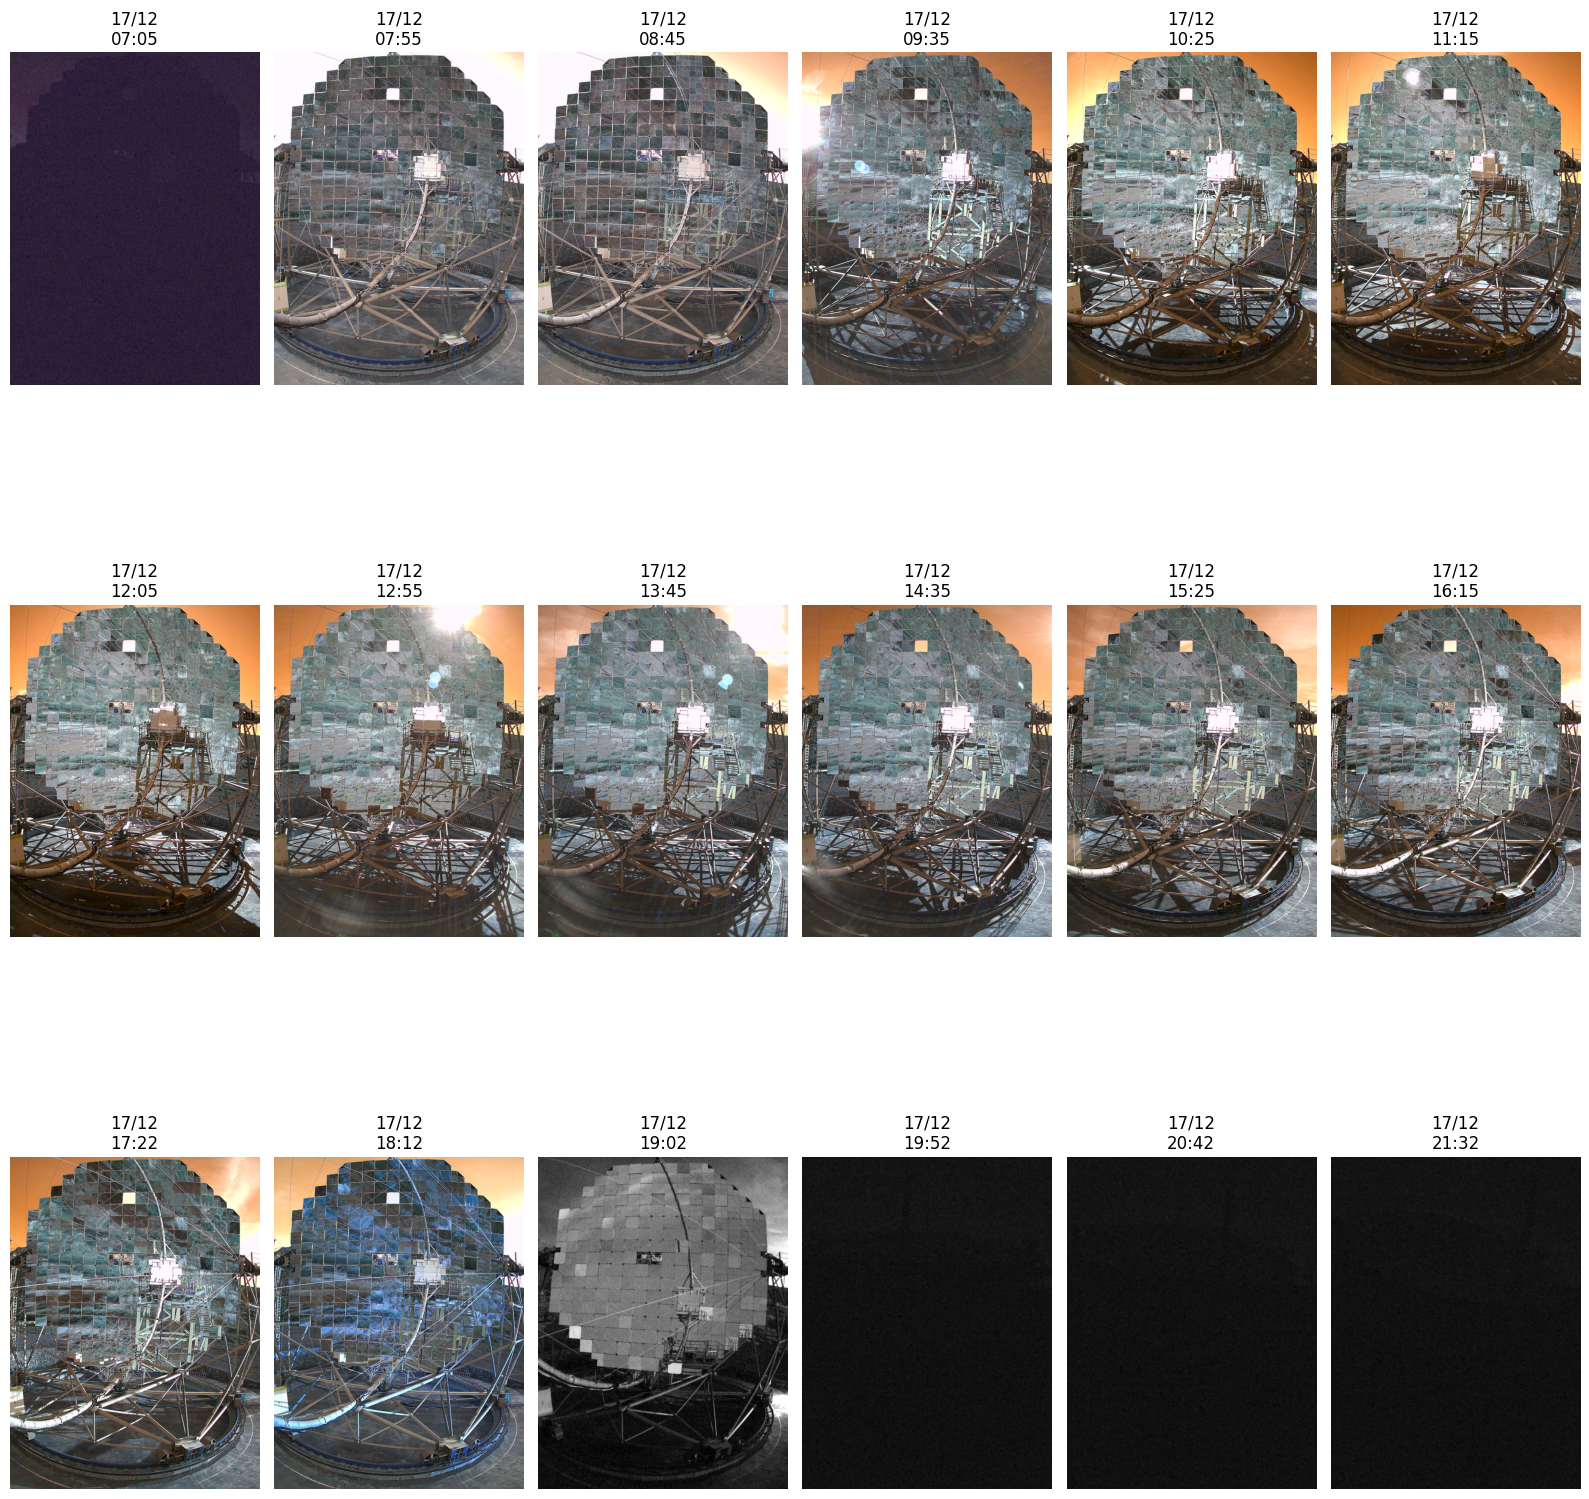

In [22]:
fig, ax = plt.subplots(3, 6, figsize=(16, 18))
axes = ax.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_axis_off()
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()

In [24]:
fnames

['IRCamM1T20251217_070547M.jpg',
 'IRCamM1T20251217_075547M.jpg',
 'IRCamM1T20251217_084547M.jpg',
 'IRCamM1T20251217_093547M.jpg',
 'IRCamM1T20251217_102547M.jpg',
 'IRCamM1T20251217_111547M.jpg',
 'IRCamM1T20251217_120547M.jpg',
 'IRCamM1T20251217_125547M.jpg',
 'IRCamM1T20251217_134547M.jpg',
 'IRCamM1T20251217_143547M.jpg',
 'IRCamM1T20251217_152547M.jpg',
 'IRCamM1T20251217_161547M.jpg',
 'IRCamM1T20251217_172254M.jpg',
 'IRCamM1T20251217_181254M.jpg',
 'IRCamM1T20251217_190254M.jpg',
 'IRCamM1T20251217_195254M.jpg',
 'IRCamM1T20251217_204254M.jpg',
 'IRCamM1T20251217_213254M.jpg']

In [28]:
df = pd.DataFrame(all_features)
df['fnames'] = fnames
df['label'] = labels

In [29]:
df['label'].head()

0    17/12\n07:05
1    17/12\n07:55
2    17/12\n08:45
3    17/12\n09:35
4    17/12\n10:25
Name: label, dtype: object

In [13]:
df.keys()

Index(['mean_brightness', 'std_brightness', 'p10_brightness', 'p90_brightness',
       'dynamic_range', 'warm_bright_fraction', 'bright_saturated_frac',
       'LR_asymmetry', 'LR_asymmetry_abs', 'TB_asymmetry', 'TB_asymmetry_abs',
       'sky_brightness', 'sky_blue_ratio', 'mean_saturation', 'mean_hue',
       'BR_ratio', 'mean_a_channel', 'mean_b_channel', 'sharpness', 'entropy',
       'dark_fraction', 'bright_fraction', 'fnames', 'label'],
      dtype='object')

<Axes: >

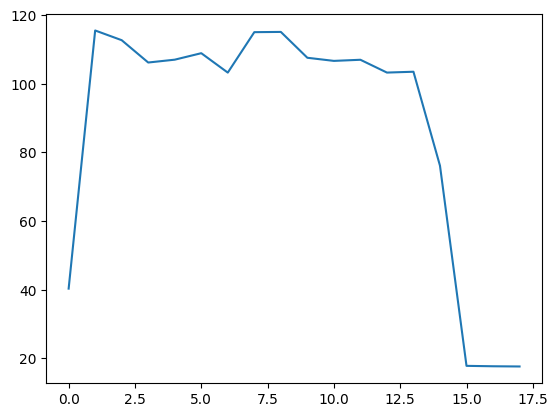

In [30]:
df['mean_brightness'].plot()

<Axes: >

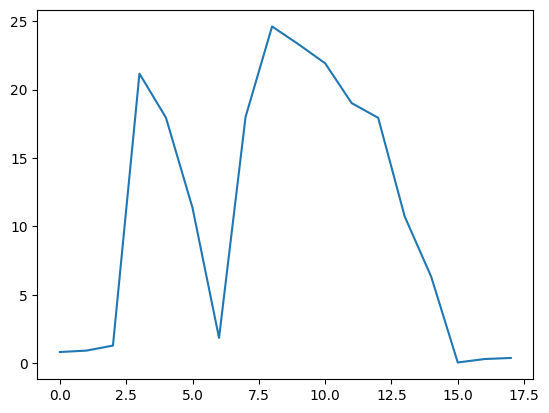

In [31]:
df['LR_asymmetry_abs'].plot()

In [45]:
df[(df['LR_asymmetry_abs'] < 11) & (df['mean_brightness'] > 85)]['label']

1     17/12\n07:55
2     17/12\n08:45
6     17/12\n12:05
13    17/12\n18:12
Name: label, dtype: object

In [ ]:
BASE_DIR = "/media/pgliwny/ADATA HD3303/Computer_Vision_system"
img_path = os.path.join(BASE_DIR, "data/MAGIC/IRCam/IRCamera/2025/12/16/IRCamM1T20251216_091547M.jpg")

In [ ]:
img = Image.open(f)
img_array = np.array(img)

plt.imshow(img_array)